<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((1024,1024)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving surf.jpg to surf.jpg

Upload Style Image


Saving wave.jpg to wave.jpg
Content Path: <_io.BytesIO object at 0x7fa9d2dcdf90>
Style Path: <_io.BytesIO object at 0x7faaa5080810>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda().detach()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda().detach()


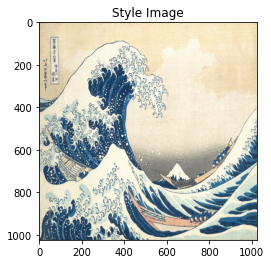

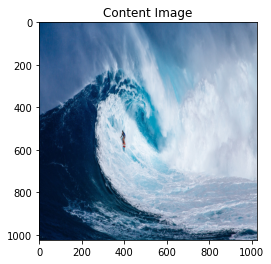

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [5]:
import re
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True) #.features.eval()

    for i, layer in self.vgg.features.named_children():
      if isinstance(layer, nn.MaxPool2d):
        self.vgg.features[int(i)] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
    
    self.vgg = self.vgg.features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
  
  def get_vgg(self):
    return self.vgg
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_layers = ["conv4_2"]
style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]

content_indices = [ vgg_names.index(name) for name in content_layers ]
style_indices = [ vgg_names.index(name) for name in style_layers ]
requested = style_indices + content_indices

# Create the vgg network in eval mode
# with our forward method that returns the outputs of the intermediate layers we requested
vgg_content = VGGIntermediate(content_indices)
vgg_style = VGGIntermediate(style_indices)
vgg_input = VGGIntermediate(requested)

vgg_content.requires_grad_(False)
vgg_style.requires_grad_(False)
vgg_input.requires_grad_(False)

vgg_content.cuda()
vgg_style.cuda()
vgg_input.cuda()

style_output = vgg_style(style_image)
content_output = vgg_content(content_image)

<ipython-input-5-6b61bb9b824d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-5-6b61bb9b824d>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior i

  0%|          | 0.00/528M [00:00<?, ?B/s]

___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [7]:
def gram_matrix(input):
  n_channels, h, w = input.size()
  input = input.view(n_channels, h * w)

  return torch.mm(input, input.t())
  
class ContentLoss(nn.Module): # Calculate content loss for content layer l
  def __init__(self, content_map):
    super(ContentLoss, self).__init__()

    self.P = content_map

    self.mse = nn.MSELoss(reduction='sum')

  def forward(self, F):
    return .5 * self.mse(F.squeeze(), self.P)
    
class StyleLoss(nn.Module): # Calculate style loss for style layer l
  def __init__(self, style_map, style_layers):
    super(StyleLoss, self).__init__()
    
    self.L = style_layers

    self.A = gram_matrix(style_map)

    self. w = 0
    if len(self.L) != 0:
      self.w = 1 / len(self.L)

    self.mse = nn.MSELoss(reduction='sum')

  def forward(self, F):
    N, h, w = F.size()
    M = h * w

    G = gram_matrix(F.squeeze())

    E = self.mse(G, self.A) / (4 * N^2 * M^2)

    return self.w * E

class TotalLoss(nn.Module):
  def __init__(self, a, b):
    super(TotalLoss, self).__init__()

    self.a = a
    self.b = b

  def forward(self, content_loss, style_loss):
    return self.a * content_loss + self.b * style_loss

# Instantiate a content loss module for each content layer 
# with the content reference image outputs for that layer for comparison
content_loss = {}
for l in content_indices:
  content_loss[l] = ContentLoss(content_output[l].squeeze())

# Instantiate a style loss module for each style layer 
# with the style reference image outputs for that layer for comparison
style_loss = {}
for l in style_indices:
  style_loss[l] = StyleLoss(style_output[l].squeeze(), style_layers=style_layers)

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



In [8]:
# Start with a copy of the content image
content_image_cp = nn.Parameter(content_image.clone().squeeze())
content_image_cp = content_image_cp.requires_grad_(True) 

# Set the optimizer to update the image
# (Set requires_grad to True on the image to allow it to accumulate a gradient)
optimizer = optim.Adam([content_image_cp], lr=.09)

b = 10
a = b * 1e-4
objective = TotalLoss(a=a, b=b)

# Run the optimizer on the images to change the image
# using the loss of the style and content layers
# to backpropagate errors
EPOCHS = 500
gc.collect()

loop = tqdm(total=EPOCHS, position=0, leave=False)

for epoch in range(EPOCHS):
  optimizer.zero_grad()

  content_image_output = vgg_input(content_image_cp)

  L_c = 0
  L_s = 0
  for key in content_image_output.keys():
    if key in content_loss:
      # print("Content: ", content_loss[key](content_image_output[key]))
      L_c += content_loss[key](content_image_output[key])
    else:
      # print("Style: ", style_loss[key](content_image_output[key]))
      L_s += style_loss[key](content_image_output[key])
  
  loss = objective(L_c, L_s)
  loss.backward()
  
  optimizer.step()

  # torch.clamp(content_image_cp, 0., 1.)

  mem = torch.cuda.memory_allocated() / 1e9

  loop.set_description('epoch:{} memory:{:.3f} loss:{:.4f}'.format(epoch, mem, loss))
  loop.update(1)  

epoch:499 memory:1.348 loss:4698928640.0000: 100%|██████████| 500/500 [00:19<00:00, 26.34it/s]

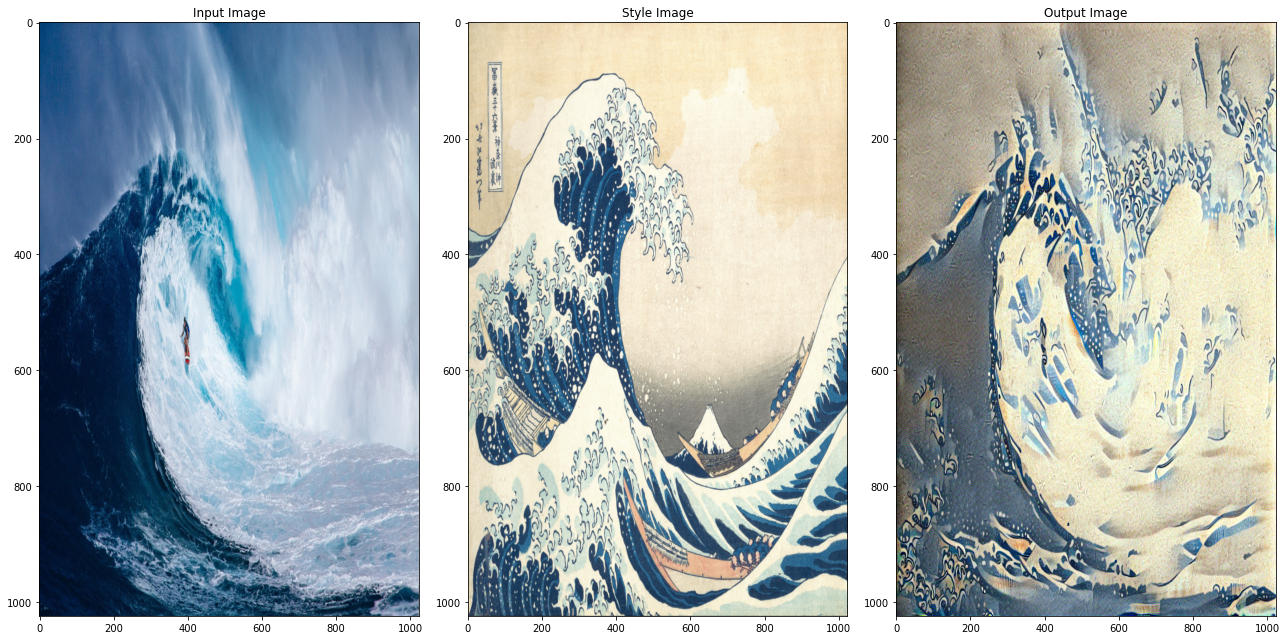

In [9]:
# Show the image
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

axs[0].imshow(content_image.squeeze().permute(1, 2, 0).cpu(), aspect='auto')
axs[0].title.set_text('Input Image')
axs[1].imshow(style_image.squeeze().permute(1, 2, 0).cpu(), aspect='auto')
axs[1].title.set_text('Style Image')
axs[2].imshow(content_image_cp.permute(1, 2, 0).detach().cpu(), aspect='auto')
axs[2].title.set_text('Output Image')
    
fig.tight_layout()

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

Equation 1:
  equation 1 is the contribution to the overall loss from the content image. We
  calculate this losss by taking half of the sum of sqaured difference between 
  the input image and the content image's feature maps after having been passed
  through the content layers of the net, they are denoted as $F_{ij}^l$ and 
  $P_{ij}^l$, respectively. Note that the supersciprt $l$ denotes which content 
  layer that feature map came from and the subscripts $i$ and $j$ simply denote 
  the element of the matrix.

Equation 3:
  equation 3 is simply the formula for computing the elements of the Gram matrix
  $G^l$ where $i$ and $j$ are the row and column indices of $G$ and $l$ is the 
  layer from which the feature map $F^l$ originated. Essentially this equation 
  tells us the the Gram matrix is the product of $F^l(F^l)^T$ where $T$ denotes
  the transpose of the matrix.

Equation 4:
  equation 4 is the contribution to the style loss due to the style layer $l$
  denoted $E_l$. It is a normalized sum of squares error where the normalizing 
  factor is $1 \over 4 N_l^2 M_l^2$ and the difference is between the Gram 
  matrix of the feature maps and the Gram matrix of the feature map of the 
  style image, denoted as $G_{ij}^l$ and $A_{ij}^l$, respectively. Note that the
  indices $i$ and $j$ simply represent a compnent of the respective matrices.


Equation 5:
  equation 5 is then the final style loss, being the weighted sum over all 
  style layers $L$ of the errors $E_l$. According to the authors, $w_l$ is equal
  to one over the number of active layers of the style layers; therefore, $w_l
  = {1 \over 5}$ for all style layers and $0$ for all content layers.
